In [397]:
"""
Deep Deterministic Policy Gradient (DDPG)
-----------------------------------------
An algorithm concurrently learns a Q-function and a policy.
It uses off-policy data and the Bellman equation to learn the Q-function,
and uses the Q-function to learn the policy.
Reference
---------
Deterministic Policy Gradient Algorithms, Silver et al. 2014
Continuous Control With D|eep Reinforcement Learning, Lillicrap et al. 2016
MorvanZhou's tutorial page: https://morvanzhou.github.io/tutorials/
Environment
-----------
Openai Gym Pendulum-v0, continual action space
Prerequisites
-------------
tensorflow >=2.0.0a0
tensorflow-proactionsbility 0.6.0
tensorlayer >=2.0.0
To run
------
python tutorial_DDPG.py --train/test
"""

import argparse
import os
import time

import gym
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

import numpy as np
import tensorflow as tf

import keras
import tensorlayer as tl
import random
import copy

'''
# add arguments in command  --train/test
parser = argparse.ArgumentParser(description='Train or test neural net motor controller.')
parser.add_argument('--train', dest='train', action='store_true', default=False)
parser.add_argument('--test', dest='test', action='store_true', default=True)
args = parser.parse_args()
'''

#####################  hyper parameters  ####################

# MountainCarContinuous-v0  Pendulum-v0
ENV_ID = 'Pendulum-v0'  # environment id
RANDOM_SEED = 2  # random seed, can be either an int number or None
RENDER = False  # render while training

ALG_NAME = 'DDPG'
TRAIN_EPISODES = 7000  # total number of episodes for training
TEST_EPISODES = 10  # total number of episodes for training
MAX_STEPS = 200  # total number of steps for each episode

LR_A = 0.000001  # learning rate for actor
LR_C = 0.000002  # learning rate for critic
GAMMA = 0.9  # reward discount
TAU = 0.01  # soft replacement
MEMORY_CAPACITY = 10000  # size of replay buffer
BATCH_SIZE = 32  # update action batch size
VAR = 6  # control exploration

###############################  DDPG  ####################################


class DDPG(object):
    """
    DDPG class
    """

    def __init__(self, action_dim, state_dim, action_range):
        self.memory = np.zeros((MEMORY_CAPACITY, state_dim * 2 + action_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.action_dim, self.state_dim, self.action_range = action_dim, state_dim, action_range
        self.var = VAR

        W_init = tf.random_normal_initializer(mean=0, stddev=0.3)
        b_init = tf.constant_initializer(0.1)

        def get_actor(input_state_shape, name=''):
            """
            Build actor network
            :param input_state_shape: state
            :param name: name
            :return: act
            """
            input_layer = keras.layers.Input(input_state_shape, name='A_input')
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='A_l1')(input_layer)
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='A_l2')(layer)
            layer = keras.layers.Dense(action_dim, activation=tf.nn.sigmoid, name='A_a')(layer)
            layer = keras.layers.Lambda(lambda x: action_range * x)(layer)
            return keras.models.Model(inputs=input_layer, outputs=layer, name='Actor' + name)

        def get_critic(input_state_shape, input_action_shape, name=''):
            """
            Build critic network
            :param input_state_shape: state
            :param input_action_shape: act
            :param name: name
            :return: Q value Q(s,a)
            """
            state_input = keras.layers.Input(input_state_shape, name='C_s_input')
            action_input = keras.layers.Input(input_action_shape, name='C_a_input')
            print(state_input)
            layer = keras.layers.Concatenate(1)([state_input, action_input])
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='C_l1')(layer)
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='C_l2')(layer)
            layer = keras.layers.Dense(1, name='C_out')(layer)
            return keras.models.Model(inputs=[state_input, action_input], outputs=layer, name='Critic' + name)

        self.actor = get_actor((state_dim))
        self.critic = get_critic((state_dim), (action_dim))
        # self.actor.train()
        # self.critic.train()

        def copy_para(from_model, to_model):
            """
            Copy parameters for soft updating
            :param from_model: latest model
            :param to_model: target model
            :return: None
            """
            for i, j in zip(from_model.trainable_weights, to_model.trainable_weights):
                j.assign(i)

        self.actor_target = get_actor((state_dim), name='_target')
        copy_para(self.actor, self.actor_target)
        # self.actor_target.eval()

        self.critic_target = get_critic((state_dim), (action_dim), name='_target')
        copy_para(self.critic, self.critic_target)
        # self.critic_target.eval()

        self.ema = tf.train.ExponentialMovingAverage(decay=1 - TAU)  # soft replacement

        self.actor_opt = tf.optimizers.Adam(LR_A)
        self.critic_opt = tf.optimizers.Adam(LR_C)

    def ema_update(self):
        """
        Soft updating by exponential smoothing
        :return: None
        """
        paras = self.actor.trainable_weights + self.critic.trainable_weights
        self.ema.apply(paras)
        for i, j in zip(self.actor_target.trainable_weights + self.critic_target.trainable_weights, paras):
            i.assign(self.ema.average(j))

    def get_action(self, s, greedy=False):
        """
        Choose action
        :param s: state
        :param greedy: get action greedy or not
        :return: act
        """
        a = self.actor(np.array([s], dtype=np.float32))[0]
        if greedy:
            return a
        return np.clip(
            np.random.normal(a, self.var), -self.action_range, self.action_range
        )  # add randomness to action selection for exploration

    def learn(self):
        """
        Update parameters
        :return: None
        """
        self.var *= .9995
        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        datas = self.memory[indices, :]
        states = datas[:, :self.state_dim]
        actions = datas[:, self.state_dim:self.state_dim + self.action_dim]
        rewards = datas[:, -self.state_dim - 1:-self.state_dim]
        states_ = datas[:, -self.state_dim:]

        with tf.GradientTape() as tape:
            actions_ = self.actor_target(states_)
            q_ = self.critic_target([states_, actions_])
            y = rewards + GAMMA * q_
            q = self.critic([states, actions])
            td_error = tf.losses.mean_squared_error(y, q)
        critic_grads = tape.gradient(td_error, self.critic.trainable_weights)
        self.critic_opt.apply_gradients(zip(critic_grads, self.critic.trainable_weights))

        with tf.GradientTape() as tape:
            a = self.actor(states)
            q = self.critic([states, a])
            actor_loss = -tf.reduce_mean(q)  # maximize the q
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_weights)
        self.actor_opt.apply_gradients(zip(actor_grads, self.actor.trainable_weights))
        self.ema_update()

    def store_transition(self, s, a, r, s_):
        """
        Store data in data buffer
        :param s: state
        :param a: act
        :param r: reward
        :param s_: next state
        :return: None
        """
        s = s.astype(np.float32)
        s_ = s_.astype(np.float32)
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def save(self):
        """
        save trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join([ALG_NAME, ENV_ID]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic_target.hdf5'), self.critic_target)

    def load(self):
        """
        load trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join([ALG_NAME, ENV_ID]))
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic_target.hdf5'), self.critic_target)




In [400]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path


class PendulumSMCEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}

    def __init__(self, g=10.0):
        self.max_speed = 10
        self.max_func = 20
        self.max_s = 10
        self.dt = 0.05
        self.g = g
        self.m = 1.0
        self.l = 1.0
        self.b = 0.1 # damping
        self.c = 2
        self.viewer = None
        self.s_integral = np.array([[0]], dtype=np.float32)
        self.k1 = 5

        high = np.array([3.5, self.max_speed, 3.5, self.max_speed], dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([self.max_func, self.max_s]), shape=(2,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, u, target):

        th, thdot, e_th, e_thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        b = self.b
        dt = self.dt
        c = self.c
        k1 = self.k1
        q_d_dd = 0
        c1 = 2
        c2 = 2
        eita = 2

        # u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        u1 = u[0]
        u2 = u[1]
        
        ###############################
        # z1_dot = q_dot - q_d_d
        # z1 = q - q_d
        # z2 = q_dot + c1 * z1 - q_d_d
        
        z1_dot = e_thdot
        z1 = e_th
        
        z2 = e_thdot + c1 * z1

        s = copy.deepcopy(z2)
        s = s / (abs(s)) * min(abs(s) * abs(u1), 1)
        # s = s / (abs(s))

        torque = self.cal_C() * (thdot) + self.cal_G(th) - self.cal_H() * (c1 * z1_dot + z1 + c2 * z2 + u2 * s)
        
        # noise = 0
        noise = (np.random.random()-0.5) * 2
        torque_a = torque - self.cal_G(th) - self.cal_C() * (thdot) + noise

        q_dot_dot = 1 / self.cal_H() * (torque_a)
        
        ########################################
        '''
        # super twisting
        s = c * (-th) + (-thdot)
        
        
        # control law
        self.s_integral += s / ( abs(s) )
        u_sw = np.array([[k1]]) * np.sqrt(abs(s)) * (s / ( abs(s) ) ) + np.array([[u]]) * self.s_integral
        u_eq = q_d_dd + c * (-thdot) + 1 / (self.cal_H()) * ( self.cal_C() * (thdot) + self.cal_G(th) )
        torque = self.cal_H() * ( u_sw + u_eq )
        
        # torque = cal_C()*(q_dot) + cal_G() - cal_H()* (c1 * z1_dot - q_d_dd + z1 + c2 * z2 + eita * s)
        
        torque_a = torque - self.cal_G(th) - self.cal_C() * (thdot)
        
        q_dot_dot = 1 / self.cal_H() * (torque_a) + (np.random.random()-0.5) * 2
        '''
        #############################################
        
        newthdot = thdot + q_dot_dot * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * dt
        newth = angle_normalize(newth)
        
        newe_th = newth - target[0]
        newe_thdot = newthdot - target[1]
        
        ############## cost ####################
        # costs = angle_normalize(newth) ** 2 + 0.1 * newthdot ** 2 + (u+5) ** 2
        # costs = angle_normalize(th) ** 2 + 0.1 * thdot ** 2 
        
        # costs = (newe_thdot + c1 * newe_th) ** 2 + 0.01 * abs(u1) + 0.01 * u2 
        costs = (c1 * abs(newe_th) + 0.1 * abs(newe_thdot)) ** 2 + 0.1 * abs(u1) + 0.02 * u2 
        # print(newthdot, newth)
        
        self.last_torque = torque
        self.state = np.array([float(newth), float(newthdot), float(newe_th), float(newe_thdot)])
        return self._get_obs(), -float(costs), False, {}, torque, newe_thdot + c1 * newe_th

    def reset(self):
        high = np.array([np.pi, self.max_speed, np.pi, self.max_speed])
        self.state = self.np_random.uniform(low=-high, high=high)
        self.last_u = None
        self.last_torque = 0
        return self._get_obs()

    def _get_obs(self):
        theta, thetadot, e_th, e_thdot = self.state
        return np.array([theta, thetadot, e_th, e_thdot], dtype=np.float32)

    def render(self, mode="human"):
        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(500, 500)
            self.viewer.set_bounds(-2.2, 2.2, -2.2, 2.2)
            rod = rendering.make_capsule(1, 0.2)
            rod.set_color(0.8, 0.3, 0.3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(0.05)
            axle.set_color(0, 0, 0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1.0, 1.0)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi / 2)
        if self.last_u is not None:
            self.imgtrans.scale = (-self.last_u / 2, np.abs(self.last_u) / 2)

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None
    
    def cal_H(self):
        return self.m * self.l**2

    def cal_C(self):
        return self.b

    def cal_G(self, th):
        return self.m*self.g*self.l*np.sin(th)

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi



Training  | Episode: 1/7000  | Episode Reward: -283.7637  | Running Time: 3.1546
Training  | Episode: 2/7000  | Episode Reward: -361.5646  | Running Time: 6.3191
Training  | Episode: 3/7000  | Episode Reward: -47.4810  | Running Time: 9.5685
Training  | Episode: 4/7000  | Episode Reward: -247.0078  | Running Time: 12.8636
Training  | Episode: 5/7000  | Episode Reward: -196.8303  | Running Time: 16.0381
Training  | Episode: 6/7000  | Episode Reward: -256.6935  | Running Time: 19.2066
Training  | Episode: 7/7000  | Episode Reward: -57.5256  | Running Time: 22.3861
Training  | Episode: 8/7000  | Episode Reward: -301.0150  | Running Time: 25.4040
Training  | Episode: 9/7000  | Episode Reward: -354.8042  | Running Time: 28.4000
Training  | Episode: 10/7000  | Episode Reward: -404.2285  | Running Time: 31.4309
Training  | Episode: 11/7000  | Episode Reward: -190.0511  | Running Time: 34.4758
Training  | Episode: 12/7000  | Episode Reward: -378.9422  | Running Time: 37.5824
Training  | Episod

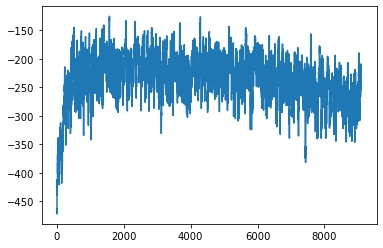

In [433]:
if __name__ == '__main__':
    # env = gym.make(ENV_ID).unwrapped
    env = PendulumSMCEnv()
    # reproducible
    env.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_range = env.action_space.high  # scale action, [-action_range, action_range]

    #agent = DDPG(action_dim, state_dim, action_range)

    t0 = time.time()
    if 1:  # train
        #all_episode_reward = []
        for episode in range(TRAIN_EPISODES):
            state = env.reset()
            episode_reward = 0
            for step in range(MAX_STEPS):
                if RENDER:
                    env.render()
                # Add exploration noise
                action = agent.get_action(state)
                
                # Target specification
                target = np.array([2 * np.sin(2*step*env.dt), 4 * np.cos(2*step*env.dt)])
                target = np.array([0, 0])
                
                state_, reward, done, info, torque, s = env.step(action, target)
                
                agent.store_transition(state, action, reward, state_)

                if agent.pointer > MEMORY_CAPACITY:
                    agent.learn()

                state = state_
                episode_reward += reward
                if done:
                    break

            if episode == 0:
                all_episode_reward.append(episode_reward)
            else:
                all_episode_reward.append(all_episode_reward[-1] * 0.9 + episode_reward * 0.1)
            print(
                'Training  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                    episode + 1, TRAIN_EPISODES, episode_reward,
                    time.time() - t0
                )
            )
        # agent.save()
        plt.plot(all_episode_reward)
        if not os.path.exists('image'):
            os.makedirs('image')
        plt.savefig(os.path.join('image', '_'.join([ALG_NAME, ENV_ID])))

In [509]:
np.save("C:/Users/Lenovo/Desktop/training-reward1101.npy",all_episode_reward)

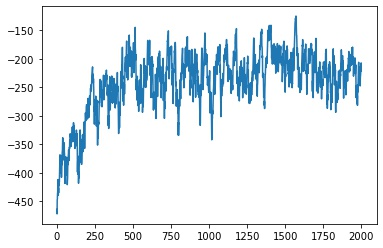

In [434]:
plt.plot(all_episode_reward[:2000])
# plt.savefig('C:/Users/Lenovo/Desktop/training-reward.png', dpi=500, bbox_inches='tight') 

In [499]:
th_r = []
thdot_r = []
env.dt=0.01
# test
# agent.load()
th_list = []
thdot_list = []
action_l = []
torque_l = []
s_l = []
eth_list =[]
ethdot_list=[]

for episode in range(1):
    state = env.reset()
    env.state = np.array([2, 1, 0.1, 0.1], dtype=np.float32)
    
    episode_reward = 0
    for step in range(2000):
        # env.render()
        # Target specification
        target = np.array([2 * np.sin(2*step*env.dt), 4 * np.cos(2*step*env.dt)])
        #target = np.array([0, 0])
        th_r.append(target[0])
        thdot_r.append(target[1])
        
        state, reward, done, info, torque, s = env.step(agent.get_action(state, greedy=True), target)
        # state, reward, done, info, torque, s = env.step([10000, 10], target)
        th_list.append(state[0])
        thdot_list.append(state[1])
        eth_list.append(state[2])
        ethdot_list.append(state[3])
        action_l.append(agent.get_action(state, greedy=True))
        torque_l.append(float(torque))
        s_l.append(float(s))
        
        episode_reward += reward
        if done:
            break
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    )

th_list2 = []
thdot_list2 = []
action_l2 = []
torque_l2 = []
s_l2 = []
eth_list2 =[]
ethdot_list2 =[]
for episode in range(1):
    state = env.reset()
    env.state = np.array([2, 1, 0.1, 0.1], dtype=np.float32)
    
    episode_reward = 0
    for step in range(2000):
        # env.render()
        # Target specification
        target = np.array([2 * np.sin(2*step*env.dt), 4 * np.cos(2*step*env.dt)])
        #target = np.array([0, 0])
        state, reward, done, info, torque, s = env.step([10000, 10], target)
        th_list2.append(state[0])
        thdot_list2.append(state[1])
        eth_list2.append(state[2])
        ethdot_list2.append(state[3])
        action_l2.append(agent.get_action(state, greedy=True))
        torque_l2.append(float(torque))
        s_l2.append(float(s))
        
        episode_reward += reward
        if done:
            break
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    )
    


Testing  | Episode: 1/10  | Episode Reward: -4696.0898  | Running Time: 40455.3331
Testing  | Episode: 1/10  | Episode Reward: -2000913.5923  | Running Time: 40456.9029


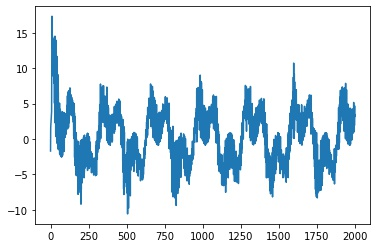

In [500]:
plt.plot(torque_l[:])
#plt.plot(torque_l2[:])

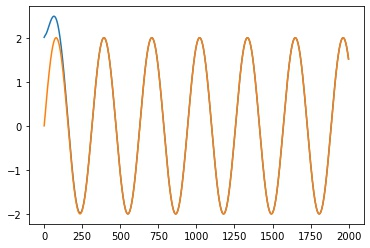

In [501]:
plt.plot(th_list[:])
#plt.plot(th_list2[:])
plt.plot(th_r[:])

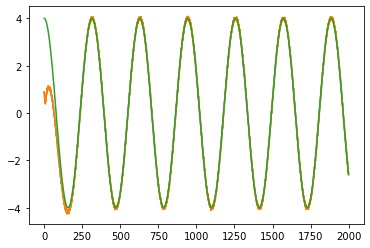

In [502]:
plt.plot(thdot_list[:])
plt.plot(thdot_list2[:])
plt.plot(thdot_r[:])

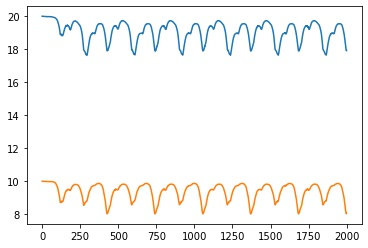

In [503]:
plt.plot(action_l[:])
# plt.plot(action_l2[:])

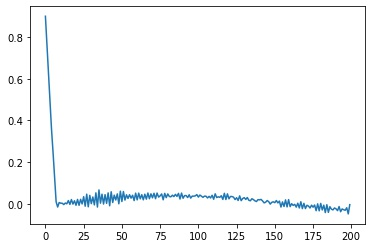

In [507]:
plt.plot(s_l[:200])
# plt.plot(s_l2[:200])
#plt.plot(thdot_list[:])
#plt.plot(th_list[:])
#plt.plot(action_l[:])

In [480]:
np.sum(abs(np.array(s_l))), np.sum(abs(np.array(s_l2)))

(61.56719800802539, 136.4419868444354)

# save model

In [508]:
agent.actor.save('2021-11-01-Noise-Sine-SMC-actor.hdf5')
agent.actor_target.save('2021-11-01-Noise-Sine-SMC-actor_target.hdf5')
agent.critic.save('2021-11-01-Noise-Sine-SMC-critic.hdf5')
agent.critic_target.save('2021-11-01-Noise-Sine-SMC-critic_target.hdf5')

In [132]:
agent.actor